In [9]:
import gc
import time
import os

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import regularizers
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn

from tensorflow.python.client import device_lib


from sklearn.model_selection import cross_val_score

from matplotlib import pyplot as plt

import mne

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Flatten


In [10]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [11]:
tf.test.gpu_device_name()

''

### Loading edf

In [12]:
file = "..\dataverse_files\h01.edf"
edfs_path = "..\dataverse_files"
manifest_path = "..\dataverse_files\MANIFEST.txt"

In [13]:
def load_patients_data(edfs_path):
    raw_patients_data = []
    
    edfs_file_names = [f for f in os.listdir(edfs_path) if f.endswith('.edf')]
    
    for file_name in edfs_file_names:
        path = edfs_path + '\\' + file_name 
        raw_data = mne.io.read_raw_edf(path, preload=True, verbose=False)
        raw_patients_data.append(raw_data)

    return raw_patients_data

In [14]:
raw_patients_data = load_patients_data(edfs_path)

### Filtered EEG signals segmentation

In [15]:
def get_label(edf):
    patient_edf_file_name = edf.filenames[0].split('\\')[-1]
    isSick = patient_edf_file_name.lower().startswith('s')
    return int(isSick == True) # 1 - is sick, 0 is healthy

In [16]:
def get_min_max_duration_for_classes(print_durations=False):
    min_SZ_negative_duration = float("inf") # healthy
    min_SZ_positive_duration = float("inf") # sick

    max_SZ_negative_duration = 0 # healthy
    max_SZ_positive_duration = 0 # sick

    for edf in raw_patients_data:
        duration = edf.times[-1]

        if(get_label(edf) == 0):
            min_SZ_negative_duration = duration if duration < min_SZ_negative_duration else min_SZ_negative_duration
            max_SZ_negative_duration = duration if duration > max_SZ_negative_duration else max_SZ_negative_duration
        else:
            min_SZ_positive_duration = duration if duration < min_SZ_positive_duration else min_SZ_positive_duration
            max_SZ_positive_duration = duration if duration > max_SZ_positive_duration else max_SZ_positive_duration


    print('SZ_negative: min =', min_SZ_negative_duration, ', max =', max_SZ_negative_duration)
    print('SZ_positive: min =', min_SZ_positive_duration, ', max =', max_SZ_positive_duration)
    
    return min_SZ_negative_duration, min_SZ_positive_duration, max_SZ_negative_duration, max_SZ_positive_duration

In [17]:
def crop_raw_data_to_equalize_duration_per_class():
    print("Duration per class before cropping: ")
    min_dur_neg, min_dur_pos, *_ = get_min_max_duration_for_classes(True)
    
    for edf in raw_patients_data:
        duration = edf.times[-1]

        if(get_label(edf) == 0):
            if(duration > min_dur_neg):
                edf.crop(tmin=0, tmax=min_dur_neg, include_tmax=True)
        else:
            if(duration > min_dur_pos):
                edf.crop(tmin=0, tmax=min_dur_pos, include_tmax=True)
                
    print("\nDuration per class after cropping: ")

    get_min_max_duration_for_classes(True)


In [18]:
def print_info(epochs_num_per_patient, labels):
    print('\nEpochs number per patient: ', epochs_num_per_patient)
    
    class_SZ_positive = sum(labels) 
    class_SZ_negative= len(labels)-sum(labels)

    print('\nnegative: ', class_SZ_positive)
    print('positive: ', class_SZ_negative)

In [19]:
def transform_patients_data_into_X_y_sets(patients_data, segment_duration=5.0, info=True):
    epochs_per_patient = []
    labels = []
    
    epochs_num_per_patient = []
    for edf in raw_patients_data:
        epochs = mne.make_fixed_length_epochs(edf, duration=segment_duration, preload=True, verbose=False)
        epochs_per_patient.append(epochs)
        epochs_num_per_patient.append(len(epochs))
        
        label = get_label(edf)
        labels.extend([label for epoch in epochs])
    
    epochs = mne.concatenate_epochs(epochs_per_patient)

    if info:
        print_info(epochs_num_per_patient, labels)
        
    del epochs_num_per_patient
    gc.collect()
    
    return (epochs, np.array(labels)) # (X, y)

In [20]:
# crop_raw_data_to_equalize_duration_per_class()

In [21]:
X, y = transform_patients_data_into_X_y_sets(patients_data=raw_patients_data, segment_duration=5.0)

Not setting metadata
5771 matching events found
No baseline correction applied
0 bad epochs dropped

Epochs number per patient:  [185, 182, 182, 185, 189, 186, 182, 182, 181, 223, 183, 180, 193, 173, 169, 229, 192, 241, 178, 148, 269, 182, 237, 170, 272, 217, 227, 434]

negative:  3165
positive:  2606


In [22]:
del raw_patients_data
gc.collect()

0

In [23]:
print(len(y))
print(len(X))
print(X[0].get_data().shape)

5771
5771
(1, 19, 1250)


In [24]:
X.to_data_frame().head()

,time,condition,epoch,Fp2,F8,T4,T6,O2,Fp1,F7,...,O1,F4,C4,P4,F3,C3,P3,Fz,Cz,Pz
0,0,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
1,4,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
2,8,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
3,12,1,0,0.461215,0.461215,0.308310,0.30831,0.155405,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,-0.150405,-0.30331,0.0025,0.0025,-0.303310
4,16,1,0,0.461215,0.461215,0.461215,0.30831,0.155405,0.0025,0.0025,...,-0.30331,0.0025,0.155405,0.0025,0.0025,-0.150405,-0.30331,0.0025,0.0025,-0.150405


In [25]:
X[0].to_data_frame().head()

,time,condition,epoch,Fp2,F8,T4,T6,O2,Fp1,F7,...,O1,F4,C4,P4,F3,C3,P3,Fz,Cz,Pz
0,0,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
1,4,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
2,8,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
3,12,1,0,0.461215,0.461215,0.308310,0.30831,0.155405,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,-0.150405,-0.30331,0.0025,0.0025,-0.303310
4,16,1,0,0.461215,0.461215,0.461215,0.30831,0.155405,0.0025,0.0025,...,-0.30331,0.0025,0.155405,0.0025,0.0025,-0.150405,-0.30331,0.0025,0.0025,-0.150405


In [26]:
# ### Data preparation

# np.set_printoptions(precision=50)

# x_data = X.get_data()
# print('x_data shape:', x_data.shape)

# column_names = X[0].to_data_frame().columns
# column_names = column_names[-19:]
# print('column_names:', column_names)

# epoch_num, channel_num, epoch_len = x_data.shape

In [27]:
# x_data[0].shape

In [28]:
# x_data[0][0].shape

In [29]:
# x_data[0]

In [30]:
# from sklearn.preprocessing import MinMaxScaler

# # scaler = MinMaxScaler(feature_range=(0, 1))
# # scaled = scaler.fit_transform(data_2['X_train'])
# # scaled

# scalers = {}
# for i in range(x_data.shape[1]):
#     scalers[i] = MinMaxScaler()
#     x_data[:, i, :] = scalers[i].fit_transform(x_data[:, i, :]) 

# # for i in range(X_test.shape[1]):
# #     X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 

In [31]:
# x_data[0].shape

In [32]:
# # x_data = x_data.swapaxes(1, 2)
# x_data_shape = x_data.shape
# print(x_data_shape)
# x_data = x_data.reshape(x_data_shape[0], x_data_shape[2], x_data_shape[1])
# x_data.shape

In [33]:
# x_data[0].shape

In [34]:
# x_data[0]

In [35]:
len(X)

5771

In [36]:
1433*5000

7165000

In [37]:
X_shape = X[0].get_data().shape
X_shape

(1, 19, 1250)

In [38]:
X_shape = (len(X), X_shape[2], X_shape[1])
X_shape

(5771, 1250, 19)

In [39]:
X_data = np.zeros(shape=X_shape)
print(X_data.shape)

for i in range(len(X)):
    df = X[i].to_data_frame().drop(['time', 'condition', 'epoch'], axis=1)
#     np.concatenate(x_data, df.to_numpy())
    epoch_data = df.to_numpy()
    X_data[i] = epoch_data
    


(5771, 1250, 19)


In [40]:
X_data

array([[[ 2.50000000e-03,  2.50000000e-03,  2.50000000e-03, ...,
          2.50000000e-03,  2.50000000e-03,  2.50000000e-03],
        [ 2.50000000e-03,  2.50000000e-03,  2.50000000e-03, ...,
          2.50000000e-03,  2.50000000e-03,  2.50000000e-03],
        [ 2.50000000e-03,  2.50000000e-03,  2.50000000e-03, ...,
          2.50000000e-03,  2.50000000e-03,  2.50000000e-03],
        ...,
        [-1.98526673e+00, -6.11370533e+00, -5.65498993e+00, ...,
         -3.82012833e+00, -2.13817186e+00,  2.90769753e+00],
        [-2.29107700e+00, -2.74979240e+00, -4.27884373e+00, ...,
         -1.67945647e+00, -2.29107700e+00,  3.08310266e-01],
        [-1.67945647e+00,  3.08310266e-01, -1.98526673e+00, ...,
          2.50000000e-03, -1.83236160e+00, -1.22074107e+00]],

       [[ 2.50000000e-03,  3.21350780e+00,  2.50000000e-03, ...,
          1.07283593e+00, -2.44398213e+00, -4.27884373e+00],
        [-2.44398213e+00,  3.08310266e-01, -2.44398213e+00, ...,
          7.67025666e-01, -3.97303346e

In [41]:
# df = X.to_data_frame().drop(['time', 'condition', 'epoch'], axis=1)

# X_data = df.to_numpy()

In [42]:
print(X_data.shape)

X_data

(5771, 1250, 19)


array([[[ 2.50000000e-03,  2.50000000e-03,  2.50000000e-03, ...,
          2.50000000e-03,  2.50000000e-03,  2.50000000e-03],
        [ 2.50000000e-03,  2.50000000e-03,  2.50000000e-03, ...,
          2.50000000e-03,  2.50000000e-03,  2.50000000e-03],
        [ 2.50000000e-03,  2.50000000e-03,  2.50000000e-03, ...,
          2.50000000e-03,  2.50000000e-03,  2.50000000e-03],
        ...,
        [-1.98526673e+00, -6.11370533e+00, -5.65498993e+00, ...,
         -3.82012833e+00, -2.13817186e+00,  2.90769753e+00],
        [-2.29107700e+00, -2.74979240e+00, -4.27884373e+00, ...,
         -1.67945647e+00, -2.29107700e+00,  3.08310266e-01],
        [-1.67945647e+00,  3.08310266e-01, -1.98526673e+00, ...,
          2.50000000e-03, -1.83236160e+00, -1.22074107e+00]],

       [[ 2.50000000e-03,  3.21350780e+00,  2.50000000e-03, ...,
          1.07283593e+00, -2.44398213e+00, -4.27884373e+00],
        [-2.44398213e+00,  3.08310266e-01, -2.44398213e+00, ...,
          7.67025666e-01, -3.97303346e

In [43]:
# X_data = X_data.reshape(-1, 5000, 19)

In [44]:
# X_data.shape

In [45]:
# df = X[0].to_data_frame()
# df = df.drop(['time', 'condition', 'epoch'], axis=1)

# X_data = df.to_numpy()

# X_data

In [46]:
input_shape = (X_data.shape[1], X_data.shape[2])
# input_shape = (5000, 19)
input_shape

(1250, 19)

In [47]:
# X_train, X_test, y_train, y_test = train_test_split(x_data, y, test_size=0.2, shuffle=True, random_state=1337)
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.2, shuffle=True, random_state=1337)

In [48]:
# from sklearn.preprocessing import MinMaxScaler

# # scaler = MinMaxScaler(feature_range=(0, 1))
# # scaled = scaler.fit_transform(data_2['X_train'])
# # scaled

# scalers = {}
# for i in range(X_train.shape[1]):
#     scalers[i] = MinMaxScaler()
#     X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

# for i in range(X_test.shape[1]):
#     X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 

In [49]:
# # 
# X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=1337)

In [50]:
y_train[:15]

array([0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0])

In [51]:
y_train.reshape(-1,1)[:15]

array([[0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0]])

In [52]:
X_train.shape

(4616, 1250, 19)

In [53]:
X_test.shape

(1155, 1250, 19)

In [54]:
y_train.ravel()

array([0, 0, 0, ..., 0, 0, 1])

In [55]:
print(X_train)

[[[ 3.83672570e+00  8.95035997e+00 -1.27690857e+00 ...  1.70604476e+00
    1.84809015e+00 -2.98145332e+00]
  [ 2.84240793e+00  7.10376981e+00 -3.26554411e+00 ...  1.70604476e+00
    3.26854411e+00 -1.70304476e+00]
  [ 9.95817774e-01  5.68331585e+00 -5.68031585e+00 ...  8.53772378e-01
    2.84240793e+00 -2.41327174e+00]
  ...
  [-1.33507673e+01 -1.30666765e+01 -3.26554411e+00 ... -1.57655390e+01
   -6.67463363e+00  3.83672570e+00]
  [-7.10076981e+00 -8.80531457e+00 -2.55531713e+00 ... -1.19303133e+01
   -4.82804347e+00  4.68899808e+00]
  [-5.39622506e+00 -7.66895140e+00 -3.54963491e+00 ... -1.02257685e+01
   -4.68599808e+00  2.70036253e+00]]

 [[ 1.11645747e+01  9.02390286e+00  2.75479240e+00 ...  2.60188726e+00
   -6.09120533e-01 -1.37364620e+00]
  [ 9.78842853e+00  7.95356693e+00  2.14317186e+00 ...  2.44898213e+00
   -1.37364620e+00 -2.29107700e+00]
  [ 1.17761953e+01  7.64775666e+00  1.37864620e+00 ...  3.21350780e+00
   -4.56215400e-01 -2.44398213e+00]
  ...
  [ 1.77394955e+01  1.1

In [56]:
validation_data_ratio = 0.2
# input_shape = Input(shape=input_shape)
print('input_shape:', input_shape)
batch_size = 128
# n_steps = traingen.samples // BATCH_SIZE
# n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

input_shape: (1250, 19)


In [57]:
import random
rnd_seed = random.randint(0, 1000000)
print(rnd_seed)

14268


In [58]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, AveragePooling2D, AveragePooling1D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm

In [59]:
from tensorflow.keras import layers

def LSTM(input_shape, opt):

    model=tf.keras.Sequential()
    

    units = 90
    dropout_rate = 0.002 * units if units < 100 else 0.15

    #model.add(Bidirectional(layers.LSTM(units,
    #                             dropout = dropout_rate),
    #                                                         input_shape=( time_steps, chans)
    #))

    model.add(layers.LSTM(units,
                          input_shape=input_shape,
                          dropout = dropout_rate,
                         # return_sequences=True
            ))
    #model.add(Bidirectional(layers.LSTM(math.floor(units/2),
    #                             dropout = dropout_rate/2)))
    #
    model.add(Dense(4,kernel_initializer='he_uniform',activation='relu'))
    

    model.add(Dense(1,activation='sigmoid'))
    
    model.compile(optimizer=opt, 
          loss='binary_crossentropy',
          metrics=['accuracy'])
    
    return model

In [66]:
from tensorflow.keras import layers

def LSTM(input_shape, opt):    

    model = Sequential()
    model.add(layers.LSTM(100,input_shape=input_shape))  #35 days, 51 features
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=opt, 
          loss='binary_crossentropy',
          metrics=['accuracy'])
    
    return model

In [67]:
opt = opt_adam = tf.keras.optimizers.Adam(learning_rate=0.00004, 
                                beta_1=0.99,
                                beta_2=0.999,
                                epsilon=1e-07)

In [68]:
model = LSTM(input_shape, opt)

In [69]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               48000     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               12928     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 61,057
Trainable params: 61,057
Non-trainable params: 0
_________________________________________________________________


In [70]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='../vgg16/V1/weights/model.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=200,
                           restore_best_weights=True,
                           mode='max')

In [55]:
history = model.fit(
    x=X_train, 
    y=y_train.reshape(-1,1),
    batch_size=32,
    validation_split=0.2,
    epochs=200, 
#     callbacks=[tl_checkpoint_1, early_stop],
    callbacks=[early_stop],
    verbose=1)

Epoch 1/200
29/29 [==============================] - 98s 3s/step - loss: 0.7097 - accuracy: 0.5066 - val_loss: 0.7162 - val_accuracy: 0.4957
Epoch 2/200
29/29 [==============================] - 101s 3s/step - loss: 0.7133 - accuracy: 0.5251 - val_loss: 0.7115 - val_accuracy: 0.4913
Epoch 3/200
29/29 [==============================] - 97s 3s/step - loss: 0.7012 - accuracy: 0.5295 - val_loss: 0.7072 - val_accuracy: 0.4913
Epoch 4/200
29/29 [==============================] - 91s 3s/step - loss: 0.6995 - accuracy: 0.5317 - val_loss: 0.7032 - val_accuracy: 0.4957
Epoch 5/200
29/29 [==============================] - 88s 3s/step - loss: 0.6916 - accuracy: 0.5382 - val_loss: 0.6991 - val_accuracy: 0.5087
Epoch 6/200
29/29 [==============================] - 90s 3s/step - loss: 0.6884 - accuracy: 0.5459 - val_loss: 0.6953 - val_accuracy: 0.5043
Epoch 7/200
29/29 [==============================] - 90s 3s/step - loss: 0.6825 - accuracy: 0.5688 - val_loss: 0.6916 - val_accuracy: 0.4957
Epoch 8/200


29/29 [==============================] - 107s 4s/step - loss: 0.5309 - accuracy: 0.7413 - val_loss: 0.6276 - val_accuracy: 0.6304
Epoch 59/200
29/29 [==============================] - 103s 4s/step - loss: 0.5131 - accuracy: 0.7642 - val_loss: 0.6269 - val_accuracy: 0.6261
Epoch 60/200
29/29 [==============================] - 103s 4s/step - loss: 0.5128 - accuracy: 0.7489 - val_loss: 0.6263 - val_accuracy: 0.6348
Epoch 61/200
29/29 [==============================] - 107s 4s/step - loss: 0.5113 - accuracy: 0.7587 - val_loss: 0.6258 - val_accuracy: 0.6391
Epoch 62/200
29/29 [==============================] - 112s 4s/step - loss: 0.5115 - accuracy: 0.7620 - val_loss: 0.6255 - val_accuracy: 0.6391
Epoch 63/200
29/29 [==============================] - 117s 4s/step - loss: 0.5144 - accuracy: 0.7576 - val_loss: 0.6252 - val_accuracy: 0.6435
Epoch 64/200
29/29 [==============================] - 116s 4s/step - loss: 0.5109 - accuracy: 0.7489 - val_loss: 0.6247 - val_accuracy: 0.6478
Epoch 65/200

29/29 [==============================] - 103s 4s/step - loss: 0.3706 - accuracy: 0.8603 - val_loss: 0.6095 - val_accuracy: 0.6783
Epoch 116/200
29/29 [==============================] - 105s 4s/step - loss: 0.3869 - accuracy: 0.8548 - val_loss: 0.6094 - val_accuracy: 0.6783
Epoch 117/200
29/29 [==============================] - 103s 4s/step - loss: 0.3696 - accuracy: 0.8799 - val_loss: 0.6095 - val_accuracy: 0.6783
Epoch 118/200
29/29 [==============================] - 111s 4s/step - loss: 0.3725 - accuracy: 0.8635 - val_loss: 0.6093 - val_accuracy: 0.6783
Epoch 119/200
29/29 [==============================] - 119s 4s/step - loss: 0.3748 - accuracy: 0.8614 - val_loss: 0.6091 - val_accuracy: 0.6783
Epoch 120/200
29/29 [==============================] - 121s 4s/step - loss: 0.3724 - accuracy: 0.8701 - val_loss: 0.6088 - val_accuracy: 0.6826
Epoch 121/200
29/29 [==============================] - 107s 4s/step - loss: 0.3765 - accuracy: 0.8526 - val_loss: 0.6083 - val_accuracy: 0.6826
Epoch 

29/29 [==============================] - 103s 4s/step - loss: 0.2488 - accuracy: 0.9279 - val_loss: 0.5993 - val_accuracy: 0.7174
Epoch 173/200
29/29 [==============================] - 106s 4s/step - loss: 0.2428 - accuracy: 0.9138 - val_loss: 0.5999 - val_accuracy: 0.7174
Epoch 174/200
29/29 [==============================] - 89s 3s/step - loss: 0.2432 - accuracy: 0.9258 - val_loss: 0.6007 - val_accuracy: 0.7174
Epoch 175/200
29/29 [==============================] - 99s 3s/step - loss: 0.2510 - accuracy: 0.9170 - val_loss: 0.6009 - val_accuracy: 0.7217
Epoch 176/200
29/29 [==============================] - 95s 3s/step - loss: 0.2346 - accuracy: 0.9356 - val_loss: 0.6005 - val_accuracy: 0.7217
Epoch 177/200
29/29 [==============================] - 94s 3s/step - loss: 0.2431 - accuracy: 0.9159 - val_loss: 0.5989 - val_accuracy: 0.7217
Epoch 178/200
29/29 [==============================] - 95s 3s/step - loss: 0.2321 - accuracy: 0.9378 - val_loss: 0.5979 - val_accuracy: 0.7217
Epoch 179/2

In [65]:
history = model.fit(
    x=X_train, 
    y=y_train.reshape(-1,1),
    batch_size=32,
    validation_split=0.2,
    epochs=300, 
#     callbacks=[tl_checkpoint_1, early_stop],
    callbacks=[early_stop],
    verbose=1)

Epoch 1/300
116/116 [==============================] - 76s 648ms/step - loss: 0.7079 - accuracy: 0.5236 - val_loss: 0.7047 - val_accuracy: 0.5325
Epoch 2/300
116/116 [==============================] - 74s 641ms/step - loss: 0.6898 - accuracy: 0.5566 - val_loss: 0.6864 - val_accuracy: 0.5584
Epoch 3/300
116/116 [==============================] - 74s 635ms/step - loss: 0.6775 - accuracy: 0.5734 - val_loss: 0.6710 - val_accuracy: 0.5639
Epoch 4/300
116/116 [==============================] - 74s 635ms/step - loss: 0.6633 - accuracy: 0.5861 - val_loss: 0.6581 - val_accuracy: 0.5790
Epoch 5/300
116/116 [==============================] - 76s 653ms/step - loss: 0.6513 - accuracy: 0.6073 - val_loss: 0.6469 - val_accuracy: 0.5974
Epoch 6/300
116/116 [==============================] - 77s 660ms/step - loss: 0.6400 - accuracy: 0.6154 - val_loss: 0.6366 - val_accuracy: 0.6028
Epoch 7/300
116/116 [==============================] - 77s 661ms/step - loss: 0.6354 - accuracy: 0.6138 - val_loss: 0.6275 -


KeyboardInterrupt



In [71]:
history = model.fit(
    x=X_train, 
    y=y_train.reshape(-1,1),
    batch_size=32,
    validation_split=0.2,
    epochs=300, 
#     callbacks=[tl_checkpoint_1, early_stop],
    callbacks=[early_stop],
    verbose=1)

Epoch 1/300
116/116 [==============================] - 78s 659ms/step - loss: 0.7209 - accuracy: 0.4764 - val_loss: 0.6862 - val_accuracy: 0.5411
Epoch 2/300
116/116 [==============================] - 80s 690ms/step - loss: 0.6908 - accuracy: 0.5460 - val_loss: 0.6711 - val_accuracy: 0.5714
Epoch 3/300
116/116 [==============================] - 88s 763ms/step - loss: 0.6777 - accuracy: 0.5734 - val_loss: 0.6605 - val_accuracy: 0.5942
Epoch 4/300
116/116 [==============================] - 89s 772ms/step - loss: 0.6678 - accuracy: 0.5804 - val_loss: 0.6529 - val_accuracy: 0.6006
Epoch 5/300
116/116 [==============================] - 99s 849ms/step - loss: 0.6553 - accuracy: 0.6018 - val_loss: 0.6460 - val_accuracy: 0.6028
Epoch 6/300
116/116 [==============================] - 100s 865ms/step - loss: 0.6527 - accuracy: 0.6035 - val_loss: 0.6399 - val_accuracy: 0.6082
Epoch 7/300
116/116 [==============================] - 103s 887ms/step - loss: 0.6453 - accuracy: 0.6132 - val_loss: 0.6334

ResourceExhaustedError: Graph execution error:

Detected at node 'while/split' defined at (most recent call last):
    File "E:\Users\dt\anaconda3\envs\ml\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "E:\Users\dt\anaconda3\envs\ml\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "E:\Users\dt\anaconda3\envs\ml\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "E:\Users\dt\anaconda3\envs\ml\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "E:\Users\dt\anaconda3\envs\ml\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\dt\AppData\Local\Temp\ipykernel_22808\1805895235.py", line 1, in <cell line: 1>
      history = model.fit(
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\keras\layers\rnn\base_rnn.py", line 515, in __call__
      return super(RNN, self).__call__(inputs, **kwargs)
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\keras\layers\rnn\lstm.py", line 673, in call
      runtime) = lstm_with_backend_selection(**normal_lstm_kwargs)
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\keras\layers\rnn\lstm.py", line 1183, in lstm_with_backend_selection
      last_output, outputs, new_h, new_c, runtime = defun_standard_lstm(**params)
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\keras\layers\rnn\lstm.py", line 891, in standard_lstm
      last_output, outputs, new_states = backend.rnn(
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\keras\backend.py", line 4776, in rnn
      final_outputs = tf.compat.v1.while_loop(
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\keras\backend.py", line 4759, in _step
      output, new_states = step_function(current_input,
    File "E:\Users\dt\anaconda3\envs\ml\lib\site-packages\keras\layers\rnn\lstm.py", line 881, in step
      z0, z1, z2, z3 = tf.split(z, 4, axis=1)
Node: 'while/split'
OOM when allocating tensor with shape[32,100] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node while/split}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[sequential_1/lstm_1/PartitionedCall]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_40777]

In [52]:
# model.save('../vgg16/V1/model/')

In [57]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [58]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


In [59]:
plot_accuracy(history)

NameError: name 'history' is not defined

In [60]:
plot_loss(history)

NameError: name 'history' is not defined

In [57]:
predictions = model.predict(X_test, verbose=0)


In [58]:
predictions = np.array([0 if x < 0.5 else 1 for x in predictions])

In [59]:
print(len(predictions))
print(len(y_test))

287
287


In [60]:
print(predictions[0:15])
print(y_test[0:15])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 1 0 1 1 1 0 0 0 1 0 0 1 1 0]


In [61]:
accuracy = accuracy_score(y_test, predictions)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.5470383275261324


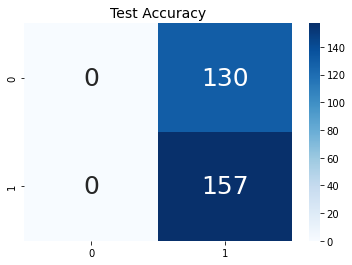

In [62]:
confusion_mtx = confusion_matrix(y_test, predictions)

ax = plt.axes()
sn.heatmap(confusion_mtx, annot=True,annot_kws={"size": 25}, cmap="Blues", ax = ax, fmt='d')
ax.set_title('Test Accuracy', size=14)
plt.show()

In [43]:
def CNN(input_shape, opt, fine_tune=False, chans=19, nb_classes=2, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    
    if dropoutType == 'SpatialDropout1D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout1D '
                         'or Dropout, passed as a string.')
    
    input1 = input_shape
    
    pooling_layer1_format = 'channels_first'
    pooling_layer2_format = 'channels_last'
   

    ##################################################################
    block1       = Conv1D(F1, (kernLength), padding = 'same',
                                  # input_shape = ( chans, samples),
                                   use_bias = False)(input1)
    block1       = BatchNormalization(axis = -1)(block1)
   
    block1       = Conv1D(5, (chans), padding='same',
                          use_bias = False )(block1)
    block1       = BatchNormalization(axis = -1)(block1)
    block1       = Activation('relu')(block1)
    block1       = AveragePooling1D(pool_size=(4),  name='apl1')(block1)
    block1       = dropoutType(dropoutRate)(block1)
 
    block2       = Conv1D(5, ( 16),
                                   use_bias = False, padding = 'same' )(block1)
    block2       = BatchNormalization(axis = -1)(block2)
    block2       = Activation('relu')(block2)
    #block2       = AveragePooling1D(pool_size=(3), name='apl2')(block2)
    block2       = dropoutType(dropoutRate)(block2)
    
    
    
    block2       = Conv1D(5, ( 16),
                                   use_bias = False, padding = 'same' )(block2)
    block2       = BatchNormalization(axis = -1)(block2)
    block2       = Activation('relu')(block2)
    block2       = dropoutType(dropoutRate)(block2)
 
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(1, name = 'dense',  kernel_constraint = max_norm(norm_rate))(flatten)
    
    softmax      = Activation('sigmoid', name = 'sigmoid')(dense)
    
    model = Model(inputs=input1, outputs=softmax)
    
    model.compile(optimizer=opt, 
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    return model

In [44]:
opt = keras.optimizers.Adam(learning_rate=0.001)

In [45]:
model = CNN(input_shape, opt, chans=19, fine_tune=0)

ValueError: Layer "conv1d" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor: shape=(), dtype=int32, numpy=5000>, <tf.Tensor: shape=(), dtype=int32, numpy=19>]

In [ ]:
model.summary()

In [ ]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='../vgg16/V1/weights/model.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=15,
                           restore_best_weights=True,
                           mode='min')

In [ ]:
history = model.fit(
    x=X_train, 
    y=y_train.reshape(-1,1),
    batch_size=32,
    validation_split=0.2,
    epochs=50, 
#     callbacks=[tl_checkpoint_1, early_stop],
    callbacks=[early_stop],
    verbose=1)

In [ ]:
# model.save('../vgg16/V1/model/')

In [ ]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


In [ ]:
plot_accuracy(history)

In [ ]:
plot_loss(history)

In [ ]:
predictions = model.predict(X_test, verbose=0)


In [ ]:
predictions = np.array([0 if x < 0.5 else 1 for x in predictions])

In [ ]:
print(len(predictions))
print(len(y_test))

In [ ]:
print(predictions[0:15])
print(y_test[0:15])

In [ ]:
accuracy = accuracy_score(y_test, predictions)
print("Test Accuracy:", accuracy)

In [ ]:
confusion_mtx = confusion_matrix(y_test, predictions)

ax = plt.axes()
sn.heatmap(confusion_mtx, annot=True,annot_kws={"size": 25}, cmap="Blues", ax = ax, fmt='d')
ax.set_title('Test Accuracy', size=14)
plt.show()

## TESTS

In [ ]:
X_train.shape


In [ ]:
X_train[0]

In [ ]:
X_train[0].transpose().shape

In [ ]:
X_train[0].shape

In [ ]:
X_train.reshape(3595, 1250, 19)

In [ ]:
X_train.transpose()[0].shape

In [ ]:
X_train[0].transpose()

In [ ]:
X_train.swapaxes(1, 2)

In [ ]:
X_train = X_train.swapaxes(1, 2).shape